### Теория

Что такое переобученная (overfitting) модель?

Это когда значения функции потерь начинают расходиться на тренировочных и валидационных данных.

Причин переобучения может быть много:
- Слишком сложная модель;
- Недостаток данных;
- Неправильное разделение данных;
- Неподходящая архитектура модели;
- Некорректные гиперпараметры.

Наша модель слишком сложная для данной задачи, поэтому может переобучаться. Грубоговоря, сейчас мы стреляем из танка по воробьям =)

С помощью слоя nn.Dropout() мы упростим нашу модель.

Суть метода заключается в том, что мы:
- можем убрать некоторые слои;
- можем убрать некоторые нейроны;
- комбинация вышеперечисленного.

Минусы способа:
- не всегда работает;
- снижение точности.

**О том, как работает слой nn.Dropout().**

Поскольку нейронная сеть полносвязная, то каждый элемент на входе (input) взаимодействует с каждым элементом первого линейного слоя. Все элементы первого линейного слоя взаимодействуют со всем элементами второго линейного слоя.

При применении слоя nn.Dropout() к первому линейному сигнал до первого слоя будет распространяться без изменений. Далее, с указанной долей вероятности (обычно p=0.2-0.5) отключается случайно каждый нейрон на первом линейном слое. И так при каждом новом бачте.

Оставшиеся включенными нейроны будут брать функцию отключенных на себя, тем самым расширяя свою функциональность, что как правило приводит к улучшению модели.

**ВАЖНЫЙ НЮАНС**

Данный слой нужен только, чтобы обучать модель!

На валидации и тестировании его необходимо отключать. В этих случаях необходима вся сеть полностью!

Включать и отключать Dropout() мы можем с помощью уже известных методов:
- model.train() - переводит модель в режим тренировки (nn.Dropout() - активен)
- model.eval() - переводит модель в режим предсказаний (nn.Dropout() - выключен)

In [ ]:
# Пример использования nn.Dropout()

import torch.nn as nn

model = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Dropout(p=0.5),  # Dropout слой с вероятностью отключения 50%
    nn.Linear(20, 10),
    nn.Softmax(dim=1)
)

### Импорты

In [2]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import v2

import os
import matplotlib.pyplot as plt
import numpy as np

import json
from tqdm import tqdm
from PIL import Image

plt.style.use('dark_background')

### Рассмотрим на примере задачи классификации

#### Подготовка данных для обучения

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
### Пробуем для 'cuda'
class MNISTDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.len_dataset = 0 # длина датасет
        self.data_list = [] # список кортежей путей до файла и позиции в onehot векторе

        # итерируемся по папке с основными файлами
        for path_dir, dir_list, file_list in os.walk(path):
            if path_dir == path:
                self.classes = sorted(dir_list)
                self.class_to_idx = {
                    cls_name: i for i, cls_name in enumerate(self.classes)
                    }
                continue

            cls = path_dir.split('/')[-1]

            for name_file in file_list:
                file_path = os.path.join(path_dir, name_file)
                self.data_list.append((file_path, self.class_to_idx[cls]))

            self.len_dataset += len(file_list)

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        file_path, target = self.data_list[index]
        sample = Image.open(file_path)

        if self.transform is not None:
            sample = self.transform(sample)
            target = self.transform(target)

        return sample, target

In [5]:
# Преобразование для изображений
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5, ), std=(0.5, ))
    ]
)

In [6]:
# создание датасетов
train_data = MNISTDataset('mnist/training', transform=transform)
test_data = MNISTDataset('mnist/testing', transform=transform)

In [7]:
train_data, val_data = random_split(train_data, [0.7, 0.3])

In [8]:
# Создание загрузчиков
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

#### Создание модели с nn.Dropout()

In [36]:
# создаем наш класс с dropout()
class MyModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 256)
        self.layer_2 = nn.Linear(256, output)
        self.dropout = nn.Dropout(0.25)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        x = self.dropout(x)
        out = self.layer_2(x)

        return out

In [37]:
# инициализируем модель
model = MyModel(784, 10).to(device)

In [38]:
# Проверяем правильность построения модели
input = torch.rand([16, 784], dtype=torch.float32).to(device)

out = model(input)
out.shape    # (16,10)

torch.Size([16, 10])

In [39]:
# выбираем функцию потерь и оптимизатор градиентного спуска
loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)

In [40]:
EPOCHS = 100
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr_list = []
best_loss = None
count = 0

In [41]:
# Цикл обучения
for epoch in range(EPOCHS):

    # Тренировка модели
    model.train()
    running_train_loss = []
    true_answer = 0
    # добавим трейн луп, чтобы видеть прогресс обучения модели
    train_loop = tqdm(train_loader, leave=False)
    for x, targets in train_loop:
        # Данные
        # (batch.size, 1, 28, 28) --> (batch.size, 784)
        x = x.reshape(-1, 28*28).to(device)
        # (batch.size, int) --> (batch.size, 10), dtype=float32
        targets = targets.reshape(-1).to(torch.int32)
        targets = torch.eye(10)[targets].to(device)

        # Прямой проход + расчет ошибки модели
        pred = model(x)
        loss = loss_model(pred, targets)

        # Обратный проход
        opt.zero_grad()
        loss.backward()
        
        # Шаг оптимизации
        opt.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)

        true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()

        train_loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}")


    # Расчет значения метрики
    running_train_acc = true_answer / len(train_data)

    # Сохранение значения функции потерь и метрики
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)

    # Проверка модели (Валидация)
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer = 0
        for x, targets in val_loader:
            # Данные
            # (batch.size, 1, 28, 28) --> (batch.size, 784)
            x = x.reshape(-1, 28*28).to(device)
            # (batch.size, int) --> (batch.size, 10), dtype=float32
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(10)[targets].to(device)

            # Прямой проход + расчет ошибки модели
            pred = model(x)
            loss = loss_model(pred, targets)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)

            true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()

        # Расчет значения метрики
        running_val_acc = true_answer / len(val_data)

        # Сохранение значения функции потерь и метрики
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)

        lr_scheduler.step(mean_val_loss)
        lr = lr_scheduler._last_lr[0]
        lr_list.append(lr)

        print(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}, train_acc={running_train_acc:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}")

        # добавляем две проверки, для сохранения лучшей модели
        if best_loss is None:
            best_loss = mean_val_loss
      
        if mean_val_loss < best_loss:
            best_loss = mean_val_loss
            
            # если модель улучшила свои показатели, то отсчет эпох пойдет заново
            # обнуляем счетчик
            count = 0
            
            # так же сохраняем словарь в случае улучшения модели
            checkpoint = {
                'state_model': model.state_dict(),
                'state_opt': opt.state_dict(),
                'state_lr_scheduler': lr_scheduler.state_dict(),
                'loss':{
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'best_loss': best_loss
                },
                'metric':{
                    'train_acc': train_acc,
                    'val_acc': val_acc
                },
                'lr': lr_list,
                'epoch':{
                    'EPOCHS': EPOCHS,
                    'save_epoch': epoch
                }
            }
    
            
    
            torch.save(checkpoint, f'model_state_dict_epoch_{epoch+1}.pt')
            print(f"На эпохе: {epoch+1}, сохранена модель со значением функции потерь на валидаци: {mean_val_loss:.4f}", end='\n\n')

        # условие, для остановки обучения по достижению счетчиком определенного значения!
        if count >= 10:
            print(f'\033[31mОбучение остановлено на {epoch + 1} эпохе.\033[0m')
            break
            
        # в конце каждой эпохи увеличиваем счетчик на 1
        count += 1

Epoch [1/100], train_loss=0.4370, train_acc=0.8678, val_loss=0.2538, val_acc=0.9221


Epoch [2/100], train_loss=0.2372, train_acc=0.9292, val_loss=0.1769, val_acc=0.9461
На эпохе: 2, сохранена модель со значением функции потерь на валидаци: 0.1769



Epoch [3/100], train_loss=0.1837, train_acc=0.9446, val_loss=0.1384, val_acc=0.9578
На эпохе: 3, сохранена модель со значением функции потерь на валидаци: 0.1384



Epoch [4/100], train_loss=0.1534, train_acc=0.9530, val_loss=0.1264, val_acc=0.9619
На эпохе: 4, сохранена модель со значением функции потерь на валидаци: 0.1264



Epoch [5/100], train_loss=0.1404, train_acc=0.9575, val_loss=0.1178, val_acc=0.9667
На эпохе: 5, сохранена модель со значением функции потерь на валидаци: 0.1178



Epoch [6/100], train_loss=0.1269, train_acc=0.9620, val_loss=0.1131, val_acc=0.9669
На эпохе: 6, сохранена модель со значением функции потерь на валидаци: 0.1131



Epoch [7/100], train_loss=0.1155, train_acc=0.9645, val_loss=0.1086, val_acc=0.9690
На эпохе: 7, сохранена модель со значением функции потерь на валидаци: 0.1086



Epoch [8/100], train_loss=0.1070, train_acc=0.9665, val_loss=0.1108, val_acc=0.9668


Epoch [9/100], train_loss=0.1039, train_acc=0.9671, val_loss=0.0972, val_acc=0.9717
На эпохе: 9, сохранена модель со значением функции потерь на валидаци: 0.0972



Epoch [10/100], train_loss=0.0945, train_acc=0.9695, val_loss=0.1061, val_acc=0.9669


Epoch [11/100], train_loss=0.0953, train_acc=0.9694, val_loss=0.0971, val_acc=0.9717
На эпохе: 11, сохранена модель со значением функции потерь на валидаци: 0.0971



Epoch [12/100], train_loss=0.0886, train_acc=0.9723, val_loss=0.0968, val_acc=0.9726
На эпохе: 12, сохранена модель со значением функции потерь на валидаци: 0.0968



Epoch [13/100], train_loss=0.0878, train_acc=0.9724, val_loss=0.1086, val_acc=0.9707


Epoch [14/100], train_loss=0.0856, train_acc=0.9729, val_loss=0.0950, val_acc=0.9733
На эпохе: 14, сохранена модель со значением функции потерь на валидаци: 0.0950



Epoch [15/100], train_loss=0.0784, train_acc=0.9746, val_loss=0.0889, val_acc=0.9754
На эпохе: 15, сохранена модель со значением функции потерь на валидаци: 0.0889



Epoch [16/100], train_loss=0.0771, train_acc=0.9745, val_loss=0.0905, val_acc=0.9741


Epoch [17/100], train_loss=0.0716, train_acc=0.9765, val_loss=0.0879, val_acc=0.9754
На эпохе: 17, сохранена модель со значением функции потерь на валидаци: 0.0879



Epoch [18/100], train_loss=0.0673, train_acc=0.9776, val_loss=0.0935, val_acc=0.9737


Epoch [19/100], train_loss=0.0664, train_acc=0.9783, val_loss=0.0904, val_acc=0.9763


Epoch [20/100], train_loss=0.0663, train_acc=0.9788, val_loss=0.0848, val_acc=0.9769
На эпохе: 20, сохранена модель со значением функции потерь на валидаци: 0.0848



Epoch [21/100], train_loss=0.0619, train_acc=0.9791, val_loss=0.0920, val_acc=0.9756


Epoch [22/100], train_loss=0.0632, train_acc=0.9792, val_loss=0.0925, val_acc=0.9754


Epoch [23/100], train_loss=0.0609, train_acc=0.9792, val_loss=0.0961, val_acc=0.9745


Epoch [24/100], train_loss=0.0570, train_acc=0.9812, val_loss=0.0866, val_acc=0.9776


Epoch [25/100], train_loss=0.0552, train_acc=0.9814, val_loss=0.1052, val_acc=0.9719


Epoch [26/100], train_loss=0.0578, train_acc=0.9807, val_loss=0.0961, val_acc=0.9769


Epoch [27/100], train_loss=0.0321, train_acc=0.9888, val_loss=0.0797, val_acc=0.9802
На эпохе: 27, сохранена модель со значением функции потерь на валидаци: 0.0797



Epoch [28/100], train_loss=0.0243, train_acc=0.9922, val_loss=0.0779, val_acc=0.9809
На эпохе: 28, сохранена модель со значением функции потерь на валидаци: 0.0779



Epoch [29/100], train_loss=0.0233, train_acc=0.9923, val_loss=0.0777, val_acc=0.9816
На эпохе: 29, сохранена модель со значением функции потерь на валидаци: 0.0777



Epoch [30/100], train_loss=0.0229, train_acc=0.9923, val_loss=0.0785, val_acc=0.9808


Epoch [31/100], train_loss=0.0204, train_acc=0.9932, val_loss=0.0802, val_acc=0.9810


Epoch [32/100], train_loss=0.0213, train_acc=0.9927, val_loss=0.0781, val_acc=0.9814


Epoch [33/100], train_loss=0.0204, train_acc=0.9935, val_loss=0.0807, val_acc=0.9815


Epoch [34/100], train_loss=0.0192, train_acc=0.9932, val_loss=0.0795, val_acc=0.9809


Epoch [35/100], train_loss=0.0186, train_acc=0.9937, val_loss=0.0797, val_acc=0.9811


Epoch [36/100], train_loss=0.0193, train_acc=0.9938, val_loss=0.0782, val_acc=0.9815


Epoch [37/100], train_loss=0.0178, train_acc=0.9939, val_loss=0.0781, val_acc=0.9817


Epoch [38/100], train_loss=0.0180, train_acc=0.9939, val_loss=0.0778, val_acc=0.9816


Epoch [39/100], train_loss=0.0167, train_acc=0.9949, val_loss=0.0779, val_acc=0.9814
Обучение остановлено на 39 эпохе.


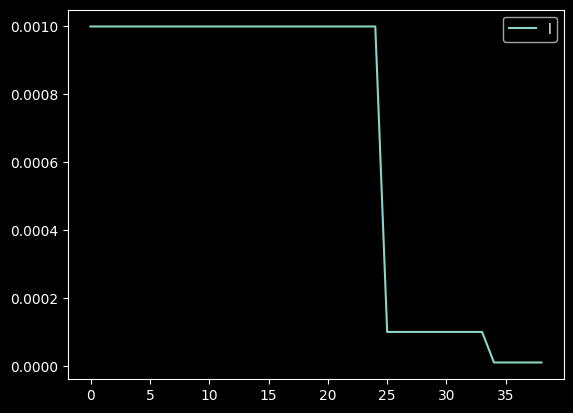

In [42]:
plt.plot(lr_list)
plt.legend('lr_list')
plt.show()

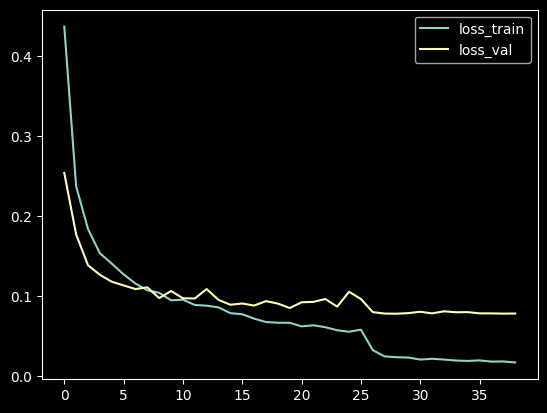

In [43]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

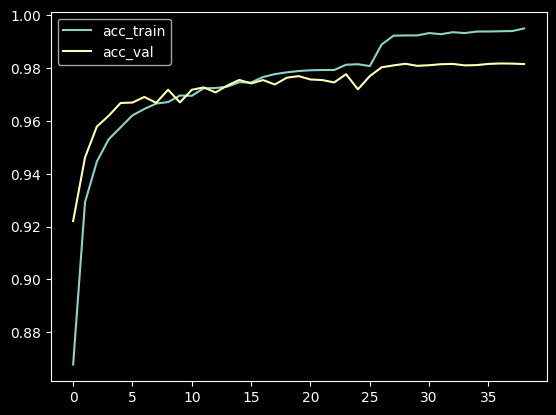

In [44]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['acc_train', 'acc_val'])
plt.show()

Хоть мы и можем наблюдать некоторое переобучение модели.

Оно не настолько существенное, как было в первых созданных моделях нейронных сетей.

Далее необходимо уже включать различные вероятности для отключения нейронов и проводить эксперименты)